In [16]:
import pandas as pd
import numpy as np
import librosa
import os
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv1D, Activation, Dropout, MaxPooling1D, LSTM, Dense, BatchNormalization
from xgboost import XGBClassifier

# Base dataset directory
DATA_DIR = "/kaggle/input/audio-speech-emotion-recognition/Voice-Emotion-Dataset"

# Load train, test and sample submission CSV files
train_df = pd.read_csv(f"{DATA_DIR}/train.csv")
test_df = pd.read_csv(f"{DATA_DIR}/test.csv")
sample_submission = pd.read_csv(f"{DATA_DIR}/sample_submission.csv")

# Feature 1: Sequence features for CNN-LSTM
n_mfcc = 20   # Number of MFCC coefficients
timesteps = 300   # Fixed length for audio sequences

# Extract time-series features (MFCC + delta + delta2)
def extract_sequence_features(file_list, folder):
    features = []
    for file in file_list:
        path = os.path.join(DATA_DIR, folder, file) # Audio file path
        y, sr = librosa.load(path, sr=None) # Load audio
        y = librosa.to_mono(y)  # Convert to mono
        y = librosa.util.normalize(y)  # Normalize volume
        y, _ = librosa.effects.trim(y)  # Trim silence
        
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)  # MFCC
        delta = librosa.feature.delta(mfcc)  # 1st derivative
        delta2 = librosa.feature.delta(mfcc, order=2)  # 2nd derivative
        stack = np.vstack([mfcc, delta, delta2])  # Stack features
        stack = stack.T          # Time x features shape
        # Pad or truncate to fixed length
        if stack.shape[0] < timesteps:
            pad_width = timesteps - stack.shape[0]
            stack = np.pad(stack, ((0, pad_width), (0, 0)), mode='constant')
        else:
            stack = stack[:timesteps, :]
        features.append(stack)
    return np.array(features)

# Extract statistical features for XGBoost (mean, std, min, max of MFCCs)
def extract_stat_embeddings(file_list, folder):
    embeddings = []
    for file in file_list:
        path = os.path.join(DATA_DIR, folder, file)
        try:
            y, sr = librosa.load(path, sr=None)  # Load audio
            y = librosa.to_mono(y)               # Mono
            y = librosa.util.normalize(y)        # Normalize
            y, _ = librosa.effects.trim(y)       # Trim silence
            
            mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40) # 40 MFCCs
            mfcc_mean = mfcc.mean(axis=1)      # Statistical features
            mfcc_std = mfcc.std(axis=1)
            mfcc_min = mfcc.min(axis=1)
            mfcc_max = mfcc.max(axis=1)
            
            embedding = np.concatenate([mfcc_mean, mfcc_std, mfcc_min, mfcc_max])
            embeddings.append(embedding)
        except:
            embeddings.append(np.zeros(160))   # Fallback for errors
    return np.array(embeddings)

# Generate CNN-LSTM inputs
X_train_seq = extract_sequence_features(train_df['Filename'], 'Train')
X_test_seq = extract_sequence_features(test_df['Filename'], 'Test')

X_train_stat = extract_stat_embeddings(train_df['Filename'], 'Train')
X_test_stat = extract_stat_embeddings(test_df['Filename'], 'Test')

# Scale statistical features
scaler = StandardScaler()
X_train_stat_scaled = scaler.fit_transform(X_train_stat)
X_test_stat_scaled = scaler.transform(X_test_stat)


# Show shapes of extracted features
print(f"Sequence features: {X_train_seq.shape}")
print(f"Statistical embeddings: {X_train_stat_scaled.shape}")


Sequence features: (1152, 300, 60)
Statistical embeddings: (1152, 160)


In [18]:
# Encode emotions (labels)
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(train_df['Label'])
num_classes = len(label_encoder.classes_)   # Number of emotion classes
y_train_cat = to_categorical(y_train_enc, num_classes=num_classes)

# Compute class weights to handle imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_enc), y=y_train_enc)
class_weight_dict = dict(enumerate(class_weights))


In [20]:
model_cnn_lstm = Sequential()

# First convolution block (extracts local time-frequency patterns)
model_cnn_lstm.add(Conv1D(128, 5, padding='same', input_shape=(timesteps, X_train_seq.shape[2])))
model_cnn_lstm.add(BatchNormalization())
model_cnn_lstm.add(Activation('relu'))
model_cnn_lstm.add(MaxPooling1D(4))
model_cnn_lstm.add(Dropout(0.2))

# Second convolution block (deeper feature extraction)
model_cnn_lstm.add(Conv1D(64, 5, padding='same'))
model_cnn_lstm.add(BatchNormalization())
model_cnn_lstm.add(Activation('relu'))
model_cnn_lstm.add(MaxPooling1D(2))
model_cnn_lstm.add(Dropout(0.2))

# LSTM layer (learns temporal dependencies in the audio sequence)
model_cnn_lstm.add(LSTM(64, return_sequences=False))

# Final classification layer (softmax for multiclass emotion prediction)
model_cnn_lstm.add(Dense(num_classes, activation='softmax'))

# Compile model (categorical crossentropy for multi-class problem)
model_cnn_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model with class weights to fix imbalance
history_cnn = model_cnn_lstm.fit(
    X_train_seq, 
    y_train_cat, 
    batch_size=32, 
    epochs=60, 
    validation_split=0.2,
    class_weight=class_weight_dict,
    verbose=1
)

print("CNN-LSTM trained!")


Epoch 1/60
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - accuracy: 0.1837 - loss: 2.0745 - val_accuracy: 0.1169 - val_loss: 2.1708
Epoch 2/60
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.2573 - loss: 1.9141 - val_accuracy: 0.2424 - val_loss: 1.9846
Epoch 3/60
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.2871 - loss: 1.7733 - val_accuracy: 0.1732 - val_loss: 1.9548
Epoch 4/60
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.3855 - loss: 1.5782 - val_accuracy: 0.1948 - val_loss: 1.9829
Epoch 5/60
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.4539 - loss: 1.4353 - val_accuracy: 0.2597 - val_loss: 1.9765
Epoch 6/60
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.4600 - loss: 1.4079 - val_accuracy: 0.3117 - val_loss: 1.7606
Epoch 7/60
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.5630 - loss: 1.2574 - val_accuracy: 0.3030 - val_loss: 2.0491
Epoch 8/60
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.6298 - loss: 1.0907 - val_accuracy: 0.3550 - v

In [21]:
# Initialize XGBoost model with tuned hyperparameters
xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=7,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='mlogloss'
)

# Apply class weights manually for XGBoost (handles imbalance)
sample_weights = np.array([class_weights[y] for y in y_train_enc])

# Train XGBoost on the statistical embeddings
xgb_model.fit(
    X_train_stat_scaled,
    y_train_enc,
    sample_weight=sample_weights,
    verbose=10  # Shows training progress
)

print("XGBoost trained!")


XGBoost trained!


In [22]:
# Get predictions from both models
cnn_pred_prob = model_cnn_lstm.predict(X_test_seq)           # (num_samples, num_classes)
xgb_pred_prob = xgb_model.predict_proba(X_test_stat_scaled)  # (num_samples, num_classes)

# Weighted average (you can tune weights)
ensemble_pred_prob = 0.6 * cnn_pred_prob + 0.4 * xgb_pred_prob

# Get final predictions
y_pred_classes = ensemble_pred_prob.argmax(axis=1)
y_pred_labels = label_encoder.inverse_transform(y_pred_classes)

# Check distribution
print("Ensemble predicted class distribution:")
print(np.bincount(y_pred_classes))

# Submit
sample_submission['Label'] = y_pred_labels
sample_submission.to_csv("submission.csv", index=False)
print("Submission saved!")


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Ensemble predicted class distribution:
[61 42 33 21 66 20 11 34]
Submission saved!


In [23]:
# Try different weights and pick the best
weights_to_test = [
    (0.5, 0.5),  # Equal
    (0.6, 0.4),  # Current
    (0.7, 0.3),  # More CNN
    (0.4, 0.6),  # More XGB
    (0.55, 0.45),  # Fine-tune
]

best_score = 0
best_weights = None

for w_cnn, w_xgb in weights_to_test:
    # Compute ensemble probabilities using chosen weight pair
    ensemble_pred_prob = w_cnn * cnn_pred_prob + w_xgb * xgb_pred_prob
    
    # Convert probability vector to predicted class index
    y_pred_classes = ensemble_pred_prob.argmax(axis=1)
    
    # Map class indices back to emotion labels
    y_pred_labels = label_encoder.inverse_transform(y_pred_classes)
    
    # Save a submission file for each weight combination

    sample_submission['Label'] = y_pred_labels
    sample_submission.to_csv(f"submission_w{w_cnn}_{w_xgb}.csv", index=False)
    print(f"Weights {w_cnn}/{w_xgb} saved. Try uploading to find best score.")


Weights 0.5/0.5 saved. Try uploading to find best score.
Weights 0.6/0.4 saved. Try uploading to find best score.
Weights 0.7/0.3 saved. Try uploading to find best score.
Weights 0.4/0.6 saved. Try uploading to find best score.
Weights 0.55/0.45 saved. Try uploading to find best score.


In [24]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# Encode labels (run as part of data preprocessing)
label_encoder = LabelEncoder()

# Fit encoder on training labels and transform them into integer indices
y_train_enc = label_encoder.fit_transform(train_df['Label'])

# Count how many unique emotion classes exist
num_classes = len(label_encoder.classes_)

# For CNN-LSTM training, you likely also created a one-hot encoding:
y_train_cat = to_categorical(y_train_enc, num_classes=num_classes)


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


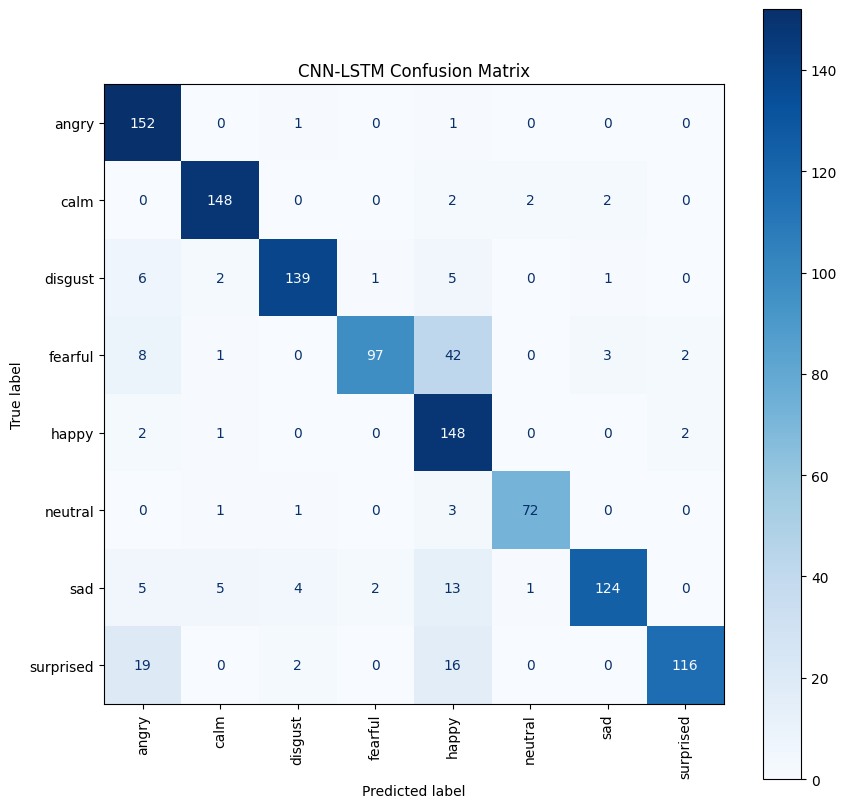

In [25]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict classes on validation or test set
y_true = y_train_enc  # true labels for training or validation set
y_pred_prob = model_cnn_lstm.predict(X_train_seq)  # or X_val_seq if you have split validation
y_pred_classes = y_pred_prob.argmax(axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes, labels=np.arange(num_classes))

# Create and display the confusion matrix plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, cmap='Blues', xticks_rotation='vertical')
plt.title("CNN-LSTM Confusion Matrix")
plt.show()


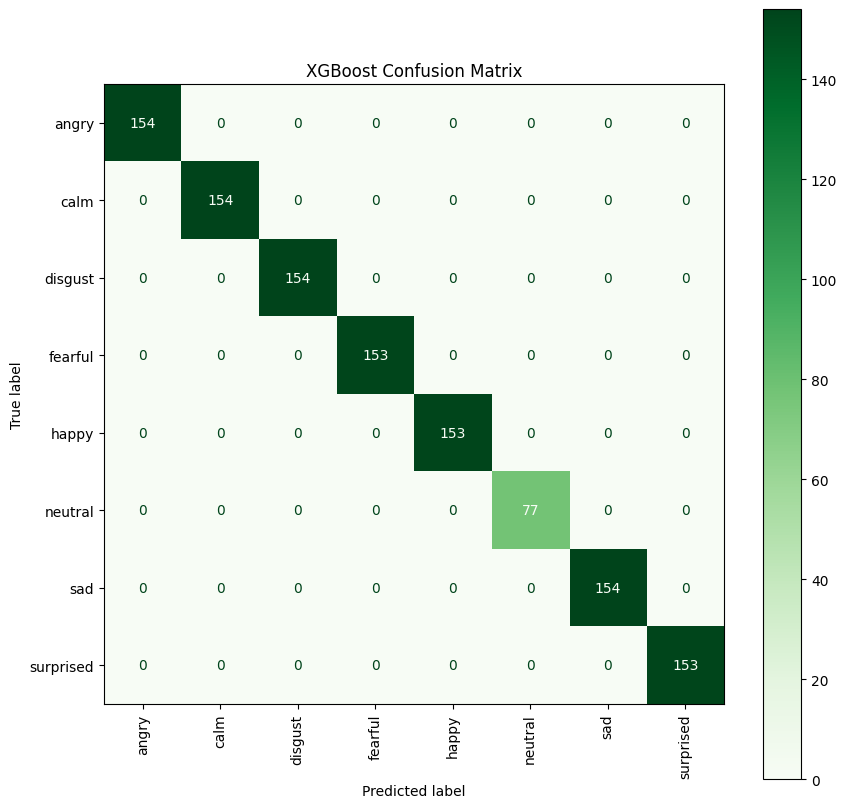

In [26]:
# Predict labels using XGBoost on the training statistical features
# (Use validation set instead if available for a fair evaluation)
xgb_pred_classes = xgb_model.predict(X_train_stat_scaled)

# Compute confusion matrix for XGBoost predictions
cm_xgb = confusion_matrix(y_train_enc, xgb_pred_classes, labels=np.arange(num_classes))


# Create and display confusion matrix plot
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=label_encoder.classes_)
fig, ax = plt.subplots(figsize=(10, 10))
disp_xgb.plot(ax=ax, cmap='Greens', xticks_rotation='vertical')
plt.title("XGBoost Confusion Matrix")
plt.show()


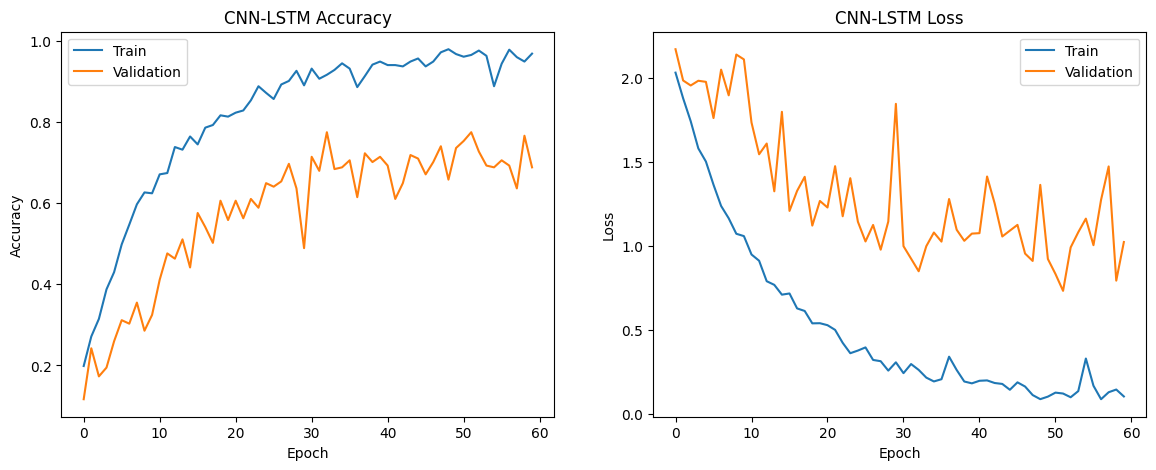

In [27]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['accuracy'], label='Train')
plt.plot(history_cnn.history['val_accuracy'], label='Validation')
plt.title('CNN-LSTM Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['loss'], label='Train')
plt.plot(history_cnn.history['val_loss'], label='Validation')
plt.title('CNN-LSTM Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


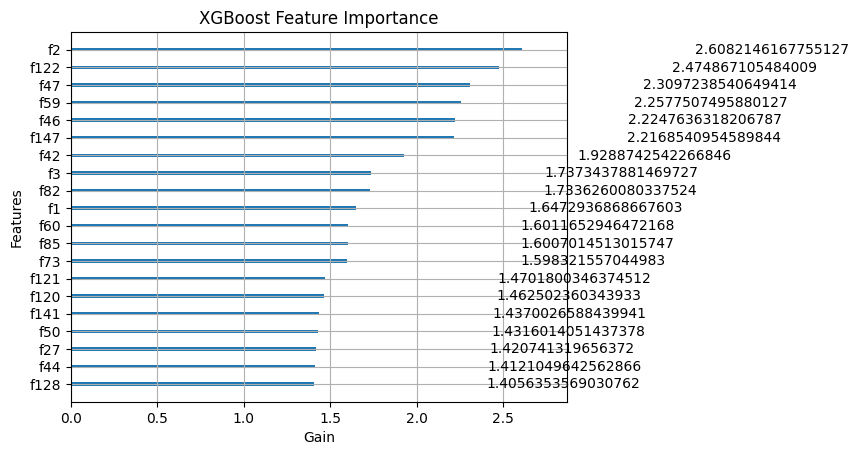

In [28]:
import matplotlib.pyplot as plt
import xgboost as xgb

# Plot top 20 most important features learned by XGBoost
# importance_type='gain' shows how much each feature contributes to model decisions
xgb.plot_importance(xgb_model, max_num_features=20, importance_type='gain', xlabel='Gain', ylabel='Features', title='XGBoost Feature Importance')
plt.show()
